In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio 
from rasterio.mask import mask
import geopandas as gp
import json
from spectral.io import envi
from emit_utils.file_checks import envi_header
import glob
import pandas as pd
import fiona
import scipy
from ch4_ime_q import *
from LatLongUTMconversion import LLtoUTM    
from pyproj import CRS

In [3]:
## Recursively go through all folders in ime_20231101 and stack csv files together into a singel dataframe 
""" 
chat gpt :')
"""
def concatenate_csvs_in_directory(root_dir):
    all_dataframes = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.csv') and not file.endswith('checkpoint.csv'):
                file_path = os.path.join(subdir, file)
                df = pd.read_csv(file_path)
                df['Max fetch (m)'] = int(re.search(r'fetch(\d+)', file).group(1))
                all_dataframes.append(df)

    if all_dataframes:
        concatenated_df = pd.concat(all_dataframes, ignore_index=True)
        return concatenated_df
    else:
        return None

## Carbon Mapper figure

In [4]:
# Get most up-to-date compute_IME_CNN data
root_directory_path = '/scratch/colemanr/emit-ghg/ime_2024_manuscript/cm_figure/out/'
result_df = concatenate_csvs_in_directory(root_directory_path)

if result_df is None:
    print("No CSV files found in the directory.")
    
result_df = result_df.drop(columns=[' CMF Min (ppmm)', ' CMF Max (ppmm)',
       ' CMF Median (ppmm)', ' CMF MAD (ppmm)', ' Salience Min (%)',
       ' Salience Max (%)', ' Salience Median (%)', ' Salience', ' Cloud',
       ' Specular', ' Flare', ' Dark', ' DetId200'])

In [5]:
# Path to plume metadata (.json) 
metadata_path = '/scratch/brodrick/methane/visions_delivery/combined_plume_metadata.json'

# Open plume metadata as nested json dict
with open(metadata_path, 'r') as f: 
    metadata = json.loads(f.read())
plume_df = pd.json_normalize(metadata['features'])

# Open manual plume annotation for source pixels
metadata_path_annotation = '/scratch/brodrick/methane/ch4_plumedir/previous_manual_annotation_oneback.json'
with open(metadata_path_annotation, 'r') as f: 
    meta = json.loads(f.read())
meta_df = pd.json_normalize(meta['features'])

# Join meta_df (properties.name) and plume_df (properties.Plume ID) 
merge_df = pd.merge(plume_df, meta_df, left_on = 'properties.Plume ID', right_on = 'properties.Plume ID')

Using pre-existing .grib file!


Ignoring index file '/scratch/colemanr/emit-ghg/grib/20230807_08:00.grib.923a8.idx' older than GRIB file


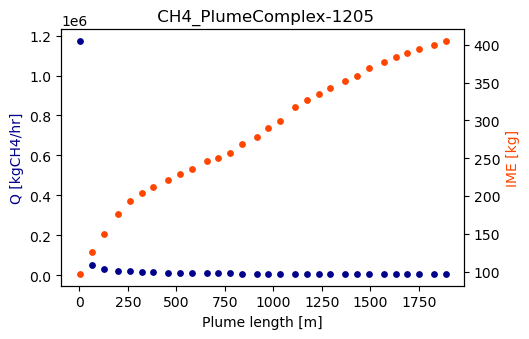

Using pre-existing .grib file!


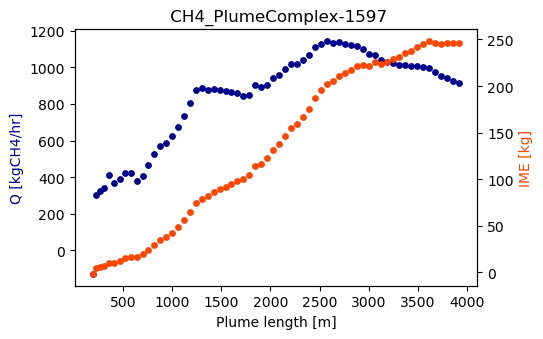

Ignoring index file '/scratch/colemanr/emit-ghg/grib/20230606_06:00.grib.923a8.idx' older than GRIB file


Using pre-existing .grib file!


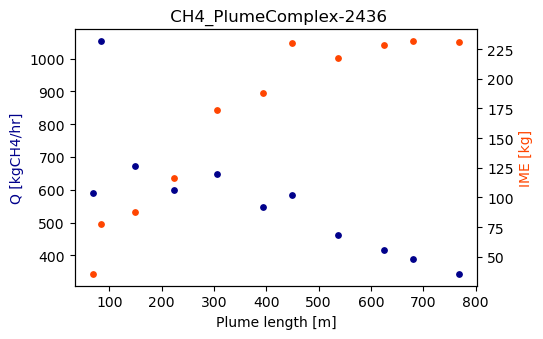

Ignoring index file '/scratch/colemanr/emit-ghg/grib/20230622_20:00.grib.923a8.idx' incompatible with GRIB file


Using pre-existing .grib file!


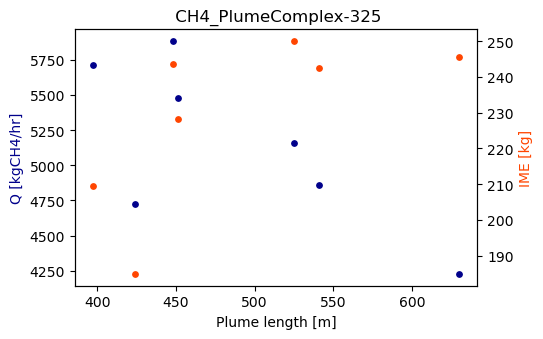

2024-02-06 13:56:36,991 INFO Welcome to the CDS
2024-02-06 13:56:36,992 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-02-06 13:56:37,216 INFO Request is queued


In [ ]:
save_path = '/scratch/colemanr/emit-ghg/grib'
plot_path = '/beegfs/scratch/colemanr/emit-ghg/out'
plume_path = '/scratch/brodrick/methane/visions_delivery/'

# Iterate through plume complexes in list 
for complex_id in result_df[' Candidate ID'][1:]:
    # Extract metadata for current complex_id
    metadata = merge_df.iloc[merge_df[merge_df['properties.Plume ID'].str.contains(complex_id.strip())].index[0]]
    pseudo_o = json.loads(metadata['properties.Psuedo-Origin'])["coordinates"]
    plume_lat = pseudo_o[1]
    plume_lon = pseudo_o[0]
    
    conc_unc = metadata['properties.Concentration Uncertainty (ppm m)']
    scene_fid = metadata['properties.fids']
    
    obs = metadata['properties.UTC Time Observed']
    day = obs[8:10]
    time = hour_round(obs[11:19])
    year = obs[0:4]
    month = obs[5:7]
    u10_avg, u10_std = access_era5(time, day, year, month, plume_lat, plume_lon, save_path)
    
    for fid in scene_fid:
        curr_folder = os.path.join(fid[4:12], 'l2bch4plm')
        curr_file = fid + '_' + complex_id.strip() + '.tif'
        full_path = os.path.join(plume_path, curr_folder, curr_file)

        # Load plume as 2D array
        with rasterio.open(full_path, 'r') as ds: 
            plume_arr = ds.read().squeeze()

        # Convert source to pixel coordinates
        x_source, y_source = ~ds.transform * (plume_lon, plume_lat)

        complex_num = re.search(r'-(\d+)', complex_id.strip()).group(1)
        q_list, ime_list, rad_list = calc_q(plume_arr, full_path, u10_avg, u10_std, complex_num, x_source, y_source, conc_unc, False, False, plot_path)
        
        fig1, ax1 = plt.subplots(1,1)
        fig1.tight_layout(pad=7)
        ax1.scatter(rad_list, q_list, color = 'darkblue', s = 15, label = 'EMIT - Transect')
        ax1.set_xlabel('Plume length [m]')
        ax1.set_ylabel('Q [kgCH4/hr]', color = 'darkblue')
        ax1.set_title(complex_id)

        ax2 = ax1.twinx()
        ax2.scatter(rad_list, ime_list, color = 'orangered', s = 15, label = 'EMIT - Transect')
        ax2.set_ylabel('IME [kg]', color = 'orangered')
        
        plt.show()

## Figure 3

In [7]:
####### Figure 3 #######
save_path = '/scratch/colemanr/emit-ghg/grib'
plot_path = '/beegfs/scratch/colemanr/emit-ghg/out'
plume_path = '/scratch/brodrick/methane/visions_delivery/'

complex_num = 1532
plume_id = 'CH4_PlumeComplex-' + str(complex_num)
fid = 'emit20231008t161127'
plume_lon = -103.45055527
plume_lat = 32.35535126
conc_unc = 378.0

curr_folder = os.path.join(fid[4:12], 'l2bch4plm')
curr_file = fid + '_' + plume_id + '.tif'
full_path = os.path.join(plume_path, curr_folder, curr_file)

with rasterio.open(full_path, 'r') as ds: 
    plume_arr = ds.read().squeeze()

# Mask out NaNs
img = np.where(plume_arr == -9999, np.nan, plume_arr)
x_source_emit, y_source_emit = ~ds.transform * (plume_lon, plume_lat)

# Calculate IME/Q from source pixel component only
u10_avg = 0.5863135
u10_std = 0.47380736
q_list, ime_list, rad_list = calc_q(plume_arr, full_path, u10_avg, u10_std, complex_num, x_source_emit, y_source_emit, conc_unc, False, False, plot_path)

In [9]:
# Get most up-to-date compute_IME_CNN data
root_directory_path = '/scratch/colemanr/emit-ghg/ime_2024_manuscript/out/'
result_df = concatenate_csvs_in_directory(root_directory_path)

if result_df is None:
    print("No CSV files found in the directory.")
    
result_df = result_df.drop(columns=[' CMF Min (ppmm)', ' CMF Max (ppmm)',
       ' CMF Median (ppmm)', ' CMF MAD (ppmm)', ' Salience Min (%)',
       ' Salience Max (%)', ' Salience Median (%)', ' Salience', ' Cloud',
       ' Specular', ' Flare', ' Dark', ' DetId200'])

result_df

,# Line name,Candidate ID,Plume Latitude (deg),Plume Longitude (deg),IME200 (kg),Fetch200 (m),Aspect ratio200,Total pixels200,AvgIME200 (kg/m),AvgFetch200 (kg/m),AvgIMEdivFetch200 (kg/m),StdIMEdivFetch200 (kg/m),CMF max200 (ppmm),Max fetch (m)
0,emit20231008t161127,emit20231008t161127,32.325506,-103.621212,368.480018,1417.144809,0.094531,273.0,285.360092,22.0,0.235185,0.049437,3445.2227,1500
1,emit20231008t161127,emit20231008t161127,32.325506,-103.621212,516.006871,1736.509309,0.085237,371.0,337.378731,27.5,0.203096,0.065125,3445.2227,1750
2,emit20231008t161127,emit20231008t161127,32.325506,-103.621212,92.711254,663.519275,0.143846,84.0,92.711254,16.5,0.115113,0.038371,896.9991,750
3,emit20231008t161127,emit20231008t161127,32.325506,-103.621212,572.023693,1922.747923,0.081240,431.0,401.734939,27.5,0.256527,0.052162,3445.2227,2000
4,emit20231008t161127,emit20231008t161127,32.325506,-103.621212,50.064474,442.724743,0.152118,53.0,50.064474,16.5,0.062161,0.020720,849.7084,500
5,emit20231008t161127,emit20231008t161127,32.325506,-103.621212,265.323780,1179.037392,0.095852,224.0,201.290949,22.0,0.162421,0.041735,3445.2227,1250
6,emit20231008t161127,emit20231008t161127,32.325506,-103.621212,163.783680,959.018611,0.113404,154.0,123.153893,22.0,0.098437,0.027626,1136.8893,1000
7,emit20231008t161127,emit20231008t161127,32.325506,-103.621212,25.702910,226.413113,0.128847,32.0,25.702910,11.0,0.042551,0.000000,767.7604,250


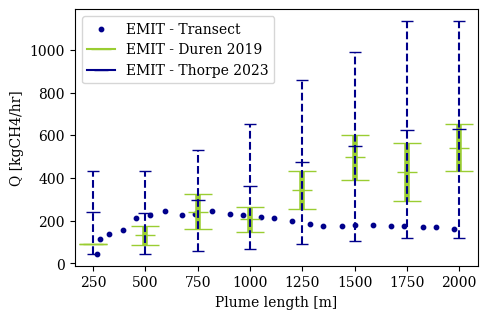

In [10]:
plt.rcParams['font.family'] = "serif"
grid = False
plot_IME = False 
plot_Q = True

# Plot IME/Q data from current transect approach

if plot_Q: 
    fig1, ax1 = plt.subplots(1,1)
    fig1.tight_layout(pad=7)
    ax1.scatter(rad_list, q_list, color = 'darkblue', s = 10, label = 'EMIT - Transect')
    ax1.set_xlabel('Plume length [m]')
    ax1.set_ylabel('Q [kgCH4/hr]')#, color = 'darkblue')

if plot_IME: 
    fig2, ax2 = plt.subplots(1,1)
    fig2.tight_layout(pad=7)
    ax2.scatter(rad_list, ime_list, color = 'orangered', s = 10, label = 'EMIT - Transect')
    ax2.set_ylabel('IME [kg]')

# Plot IME/Q data via concentric circles 
if plot_Q: 
    q_vals_duren = [a * u10_avg * 3600 for a in result_df[' AvgIMEdivFetch200 (kg/m)'].tolist()]
    q_unc_duren = [a * u10_avg * 3600 for a in result_df[' StdIMEdivFetch200 (kg/m)'].tolist()]
    q_vals_thorpe = [(a/b)* u10_avg * 3600 for a,b in zip(result_df[' IME200 (kg)'],result_df[' Fetch200 (m)'])] 
    q_unc_thorpe = [(a/b)* u10_std * 3600 for a,b in zip(result_df[' IME200 (kg)'],result_df[' Fetch200 (m)'])] 
        
if plot_IME: 
    ime_vals = result_df[' IME200 (kg)'].tolist()
if plot_IME or plot_Q: 
    fetch_max_vals = result_df['Max fetch (m)'].tolist()

for i in range(len(fetch_max_vals)): 
    if plot_IME: 
        ax2.plot(fetch_max_vals[i], ime_vals[i], marker='^', ls='none', color = 'orangered', ms=7, label = 'EMIT - Duren 2019/Thorpe 2023')
    if plot_Q: 
        eb = ax1.errorbar(fetch_max_vals[i], q_vals_duren[i], yerr=q_unc_duren[i], color='yellowgreen', linewidth = 4,  capsize=10)
        eb[-1][0].set_linestyle('solid')
        ax1.plot(fetch_max_vals[i], q_vals_duren[i], color='yellowgreen', marker='_', ms=15, label = 'EMIT - Duren 2019')
        
        eb = ax1.errorbar(fetch_max_vals[i], q_vals_thorpe[i], yerr=q_unc_thorpe[i], color='darkblue', capsize=4)
        eb[-1][0].set_linestyle('dashed')
        ax1.plot(fetch_max_vals[i], q_vals_thorpe[i], color='darkblue', marker='_', ms=10, label = 'EMIT - Thorpe 2023')
    
# Add legends 
if plot_IME: 
    handles, labels = fig2.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax2.legend(by_label.values(), by_label.keys())
if plot_Q: 
    handles, labels = fig1.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys())

# Add grid
if grid: 
    ax1.grid()
    ax2.grid()
    
plt.show()

In [9]:
####### Figure 3 #######

# Set up for running compute_ime_CNN on EMIT/AV3 Permian overpass 
plume_df = pd.DataFrame(
        {'Plume Latitude (deg)': 32.32567178, 
         'Plume Longitude (deg)': -103.62088501, 
         'Candidate ID': ['emit20231008t161127'], 
         'Line name': ['emit20231008t161127'],
         'CMF Min (ppmm)': "", 
         'CMF Max (ppmm)': "", 
         'CMF Median (ppmm)': "", 
         'CMF MAD (ppmm)': "", 
         'Salience Min (%)': "", 
         'Salience Max (%)': "", 
         'Salience Median (%)': "", 
         'Salience MAD (%)': "", 
         'Cloud': "",
         'Specular': "",
         'Flare': "", 
         'Dark': "",
        })
plume_df.to_excel('/scratch/colemanr/emit-ghg/ime_2024_manuscript/EMIT_permian.xlsx') ## -> '/scratch/colemanr/emit-ghg/ime_2024_manuscript/AV3_controlled_release.xlsx'
plume_df.to_csv('/scratch/colemanr/emit-ghg/ime_2024_manuscript/EMIT_permian.csv') ## -> '/scratch/colemanr/emit-ghg/ime_2024_manuscript/AV3_controlled_release.xlsx'

# Reproject into UTM  
plume_info_path = '/scratch/colemanr/emit-ghg/ime_2024_manuscript/EMIT_permian.csv'
plume_info = pd.read_csv(plume_info_path)
refEll = 23 # WGS-84
acq_path = '/beegfs/scratch/brodrick/methane/methane_20230813/'
reproj_path = '/scratch/colemanr/emit-ghg/ime_2024_manuscript/av3_mf/'

for i in range(len(plume_info)): 
    Lat = plume_info['Plume Latitude (deg)'][i]
    Long = plume_info['Plume Longitude (deg)'][i]
    fid = plume_info['Line name'][i]
    
    print(Lat, Long, fid)
    
    utm_zone,_,_ = LLtoUTM(refEll, Lat, Long)
    utm_zone_string = f"+proj=utm +zone={utm_zone[:-1]} +ellps=WGS84"
    epsg_code = CRS.from_string(utm_zone_string).to_epsg()
    dstSRS = 'EPSG:' + str(epsg_code)
    
    in_path = os.path.join(acq_path, fid[4:12], fid + '_ch4_mf_ort')
    out_path = os.path.join(reproj_path, fid + '_ch4_mf_ort_utm')
    
    command = f"gdalwarp -r near -t_srs {dstSRS} {in_path} {out_path} -of ENVI"
    # os.system(command)

32.32567178 -103.62088501 emit20231008t161127
Creating output file that is 2151P x 2094L.
Processing /beegfs/scratch/brodrick/methane/methane_20230813/20231008/emit20231008t161127_ch4_mf_ort [1/1] : 0Using internal nodata values (e.g. -9999) for image /beegfs/scratch/brodrick/methane/methane_20230813/20231008/emit20231008t161127_ch4_mf_ort.
Copying nodata values from source /beegfs/scratch/brodrick/methane/methane_20230813/20231008/emit20231008t161127_ch4_mf_ort to destination /scratch/colemanr/emit-ghg/ime_2024_manuscript/av3_mf/emit20231008t161127_ch4_mf_ort_utm.
...10...20...30...40...50...60...70...80...90...100 - done.


## Figure 1

In [6]:
####### Figure 1 #######

# Set up for running compute_ime_CNN on AV3 controlled release data 
plume_df = pd.DataFrame(
        {'Plume Latitude (deg)': 33.963269 , 
         'Plume Longitude (deg)': -117.336353, 
         'Candidate ID': ['4_kghr', '7_kghr', '10_kghr'], 
         'Line name': ['AV320231114t191553_L2A_GHG_main_27cba41b_CH4_ORT',
                       'AV320231114t195747_L2A_GHG_main_27cba41b_CH4_ORT',
                       'AV320231114t203137_L2A_GHG_main_27cba41b_CH4_ORT'],
         'CMF Min (ppmm)': "", 
         'CMF Max (ppmm)': "", 
         'CMF Median (ppmm)': "", 
         'CMF MAD (ppmm)': "", 
         'Salience Min (%)': "", 
         'Salience Max (%)': "", 
         'Salience Median (%)': "", 
         'Salience MAD (%)': "", 
         'Cloud': "",
         'Specular': "",
         'Flare': "", 
         'Dark': "",
        })
plume_df.to_excel('/scratch/colemanr/emit-ghg/ime_2024_manuscript/AV3_controlled_release.xlsx') ## -> '/scratch/colemanr/emit-ghg/ime_2024_manuscript/AV3_controlled_release.xlsx'
plume_df.to_csv('/scratch/colemanr/emit-ghg/ime_2024_manuscript/AV3_controlled_release.csv') ## -> '/scratch/colemanr/emit-ghg/ime_2024_manuscript/AV3_controlled_release.xlsx'

# Reproject into UTM  
plume_info_path = '/scratch/colemanr/emit-ghg/ime_2024_manuscript/AV3_controlled_release.csv'
plume_info = pd.read_csv(plume_info_path)
refEll = 23 # WGS-84
acq_path = '/scratch/colemanr/emit-ghg/ime_2024_manuscript/av3_mf/'
reproj_path = '/scratch/colemanr/emit-ghg/ime_2024_manuscript/av3_mf/'

for i in range(len(plume_info)): 
    Lat = plume_info['Plume Latitude (deg)'][i]
    Long = plume_info['Plume Longitude (deg)'][i]
    fid = plume_info['Line name'][i]
    
    print(Lat, Long, fid)
    
    utm_zone,_,_ = LLtoUTM(refEll, Lat, Long)
    utm_zone_string = f"+proj=utm +zone={utm_zone[:-1]} +ellps=WGS84"
    epsg_code = CRS.from_string(utm_zone_string).to_epsg()
    dstSRS = 'EPSG:' + str(epsg_code)
    
    in_path = os.path.join(acq_path,fid)
    out_path = os.path.join(reproj_path, fid + '_ch4_mf_ort_utm')
    
    command = f"gdalwarp -r near -t_srs {dstSRS} {in_path} {out_path} -of ENVI"
    # os.system(command)

33.963269 -117.336353 AV320231114t191553_L2A_GHG_main_27cba41b_CH4_ORT
33.963269 -117.336353 AV320231114t195747_L2A_GHG_main_27cba41b_CH4_ORT
33.963269 -117.336353 AV320231114t203137_L2A_GHG_main_27cba41b_CH4_ORT


AV3: 0.0123
AV3 resampled: 0.0138


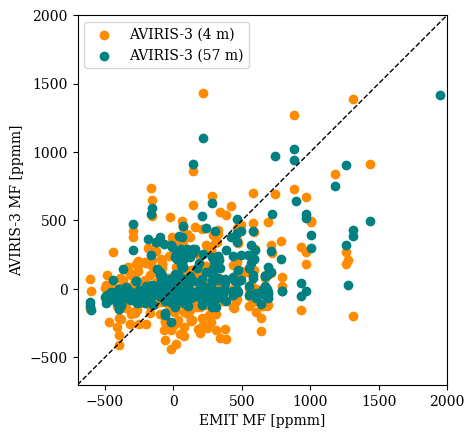

In [40]:
####### Figure 2 #######
'''
FIGURE 2 TO-DO: 
    [x] Plume visualization in QGIS (ch4_quantification.qgz on local)
    [x] Spatial resampling of AV3 to EMIT ~60 m pixels 
    [x] Create scatterplot of MF values between resampled AV3 and EMIT 
'''

def extract_from_points(vector_path, raster_path): 
    """
    ChatGPT -> extract values using a vector of point locations (center of EMIT pixels) from raster image 
    
    vector_path: shapefile of pixel center locations
    raster_path: .tif file to extract values from 
    """
    gdf = gp.read_file(vector_path)

    with rasterio.open(raster_path) as src:
        raster_values = []
        for index, point in gdf.iterrows():
            # Get the coordinates of the point
            x, y = point['geometry'].x, point['geometry'].y

            # Convert the point coordinates to pixel coordinates in the raster
            row, col = src.index(x, y)

            # Read the raster value at the specified pixel coordinates
            value = src.read(1, window=((row, row+1), (col, col+1)))

            # Append the raster value to the list
            if value.size > 0:
                raster_values.append(value[0][0])
            else: 
                raster_values.append(None)
                
        return raster_values

# AV3
vector_path = '/scratch/colemanr/emit-ghg/av3/plume_shp/CH4_complex_1532_points_32613.shp'
raster_path = '/scratch/colemanr/emit-ghg/av3/CH4_ORT_01172024/controlled_release/av3_permian_aligned.tif'
av3_raster_values = extract_from_points(vector_path, raster_path)

# AV3 resampled to EMIT spatial resolution
vector_path = '/scratch/colemanr/emit-ghg/av3/plume_shp/CH4_complex_1532_points.shp'
raster_path = '/scratch/colemanr/emit-ghg/av3/CH4_ORT_01172024/controlled_release/av3_permian_resampled_aligned.tif'
av3_resamp_raster_values = extract_from_points(vector_path, raster_path)

# EMIT
vector_path = '/scratch/colemanr/emit-ghg/av3/plume_shp/CH4_complex_1532_points.shp'
raster_path = '/scratch/brodrick/methane/visions_delivery/20231008/l2bch4plm/emit20231008t161127_CH4_PlumeComplex-1532.tif'
emit_raster_values = extract_from_points(vector_path, raster_path)

# Remove none indices for R^2 calculation
none_inds = [i for i,v in enumerate(emit_raster_values) if v == None]
emit_raster_values = [v for i, v in enumerate(emit_raster_values) if i not in none_inds]
av3_raster_values = [v for i, v in enumerate(av3_raster_values) if i not in none_inds]
av3_resamp_raster_values = [v for i, v in enumerate(av3_resamp_raster_values) if i not in none_inds]

# Calculate R^2
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(emit_raster_values, av3_raster_values)
print('AV3:', round(r_value**2,4))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(emit_raster_values, av3_resamp_raster_values)
print('AV3 resampled:', round(r_value**2,4))

# Plotting
plt.rcParams['font.family'] = "serif"
fig = plt.figure()
ax = fig.add_subplot()
plt.axline((0, 0), (1, 1), linewidth=1, color='black', linestyle = 'dashed')
plt.scatter(emit_raster_values, av3_raster_values, color = 'darkorange', label = 'AVIRIS-3 (4 m)')
plt.scatter(emit_raster_values, av3_resamp_raster_values, color = 'teal', label = 'AVIRIS-3 (57 m)')
plt.legend()
ax.set(xlim = (-700, 2000), ylim = (-700, 2000), xlabel = 'EMIT MF [ppmm]', ylabel = 'AVIRIS-3 MF [ppmm]')
ax.set_aspect('equal', adjustable='box')
plt.show()